## 교차검증

- 과적합 : 모델이 학습 데이터에만 과도하게 최적화된 현상
    - 그로인해 일반화된 데이터에서는 예측 성능이 과하게 떨어지는 현상
- 나에게 주어진 데이터에 적용한 모델의 성능을 정확히 표현하기 위해서도 유용

### 교차검증 구현하기

In [1]:
import numpy as np 
from sklearn.model_selection import KFold 

X = np.array([[1,2], [3,4], [1,2], [3,4]])
y = np.array([1,2,3,4])
kf = KFold(n_splits=2)

print(kf.get_n_splits(X))
print(kf)

for train_idx, test_idx in kf.split(X):
    print('--- idx')
    print(train_idx, test_idx)
    print('--- train data')
    print(X[train_idx])
    print('--- val data')
    print(X[test_idx])

2
KFold(n_splits=2, random_state=None, shuffle=False)
--- idx
[2 3] [0 1]
--- train data
[[1 2]
 [3 4]]
--- val data
[[1 2]
 [3 4]]
--- idx
[0 1] [2 3]
--- train data
[[1 2]
 [3 4]]
--- val data
[[1 2]
 [3 4]]


In [2]:
import pandas as pd 

wine = pd.read_csv('/home/kkyu/amr_ws/ML/data/wine.csv', index_col=0)
wine.head()

/tmp/ipykernel_10288/2502531540.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [3]:
wine['taste'] = [1. if grade > 5 else 0. for grade in wine ['quality']]

X = wine.drop(['taste', 'quality'], axis = 1)
y = wine['taste']

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2,
                                                    random_state= 13,
                                                    stratify= y)

wine_tree = DecisionTreeClassifier(max_depth=2, random_state=13)
wine_tree.fit(X_train, y_train)

y_pred_tr = wine_tree.predict(X_train)
y_pred_test = wine_tree.predict(X_test)

print('Train Acc : ', accuracy_score(y_train, y_pred_tr))
print('Test Acc : ', accuracy_score(y_test, y_pred_test))

Train Acc :  0.7371560515682124
Test Acc :  0.7276923076923076


### KFold

- K-Fold는 가장 일반적으로 사용되는 교차 검증 방법이다.
    - 보통 회귀 모델에 사용되며, 데이터가 독립적이고 동일한 분포를 가진 경우에 사용된다.

- 자세한 K-Fold 교차 검증 과정은 다음과 같다.

1. 전체 데이터셋을 Training Set과 Test Set으로 나눈다.
2. Training Set를 Traing Set + Validation Set으로 사용하기 위해 k개의 폴드로 나눈다.
3. 첫 번째 폴드를 Validation Set으로 사용하고 나머지 폴드들을 Training Set으로 사용한다.
4. 모델을 Training한 뒤, 첫번 째 Validation Set으로 평가한다.
5. 차례대로 다음 폴드를 Validation Set으로 사용하며 n번을 반복한다.
6. 총 k 개의 성능 결과가 나오며, 이 k개의 평균을 해당 학습 모델의 성능이라고 한다.

![Screenshot from 2024-02-13 11-59-56.png](<attachment:Screenshot from 2024-02-13 11-59-56.png>)
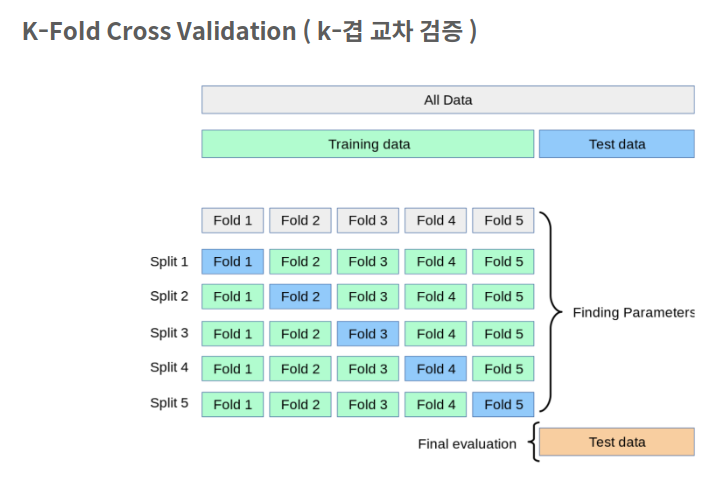

In [5]:
from sklearn.model_selection import KFold 

kfold = KFold(n_splits=5)
wine_tree_cv = DecisionTreeClassifier(max_depth=2, random_state=13)

In [6]:
for train_idx, test_idx in kfold.split(X):
    print(len(train_idx), len(test_idx))

5197 1300
5197 1300
5198 1299
5198 1299
5198 1299


### 각각의 fold에 대한 학습 후 acc

In [7]:
cv_accuracy = []

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    wine_tree_cv.fit(X_train, y_train)
    pred = wine_tree_cv.predict(X_test)
    cv_accuracy.append(accuracy_score(y_test, pred))
    
cv_accuracy

[0.6007692307692307,
 0.6884615384615385,
 0.7090069284064665,
 0.7628945342571208,
 0.7867590454195535]

### 각 acc의 분산이 크지 않다면 평균을 대표 값으로 한다

In [8]:
np.mean(cv_accuracy)

0.709578255462782

### StratifiedKFold

![Screenshot from 2024-02-13 12-54-41.png](<attachment:Screenshot from 2024-02-13 12-54-41.png>)
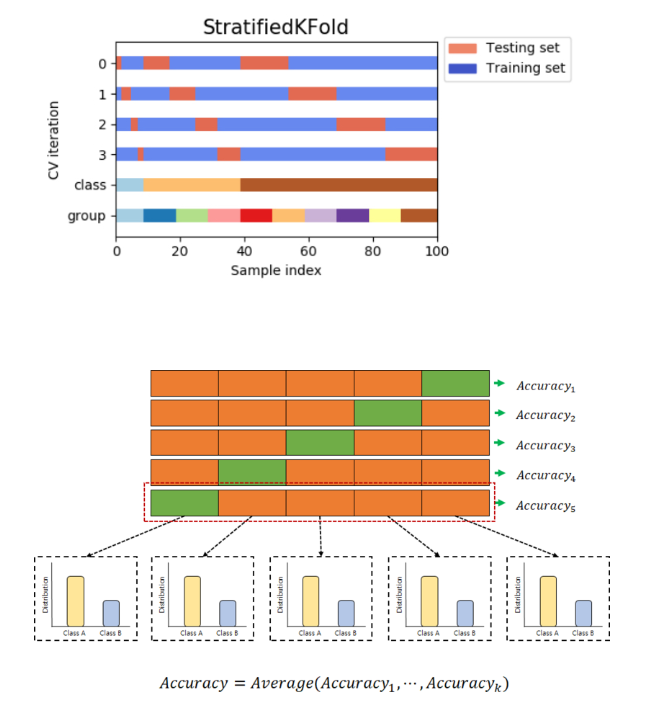

In [10]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5)
wine_tree_cv = DecisionTreeClassifier(max_depth=2, random_state=13)

cv_accuracy = []

for train_idx, test_idx in skfold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    wine_tree_cv.fit(X_train, y_train)
    pred = wine_tree_cv.predict(X_test)
    cv_accuracy.append(accuracy_score(y_test, pred))
    
cv_accuracy

[0.5523076923076923,
 0.6884615384615385,
 0.7143956889915319,
 0.7321016166281755,
 0.7567359507313318]

In [11]:
np.mean(cv_accuracy)

0.6888004974240539

### cross validation을 보다 간편히

In [12]:
from sklearn.model_selection import cross_val_score

skfold = StratifiedKFold(n_splits=5)
wine_tree_cv = DecisionTreeClassifier(max_depth=2, random_state=13)

cross_val_score(wine_tree_cv, X, y, scoring= None, cv = skfold)

array([0.55230769, 0.68846154, 0.71439569, 0.73210162, 0.75673595])

### depth가 높다고 무조건 acc가 좋아지는 것이 X

In [13]:
wine_tree_cv = DecisionTreeClassifier(max_depth = 5, random_state= 13)

cross_val_score(wine_tree_cv, X, y, scoring=None, cv = skfold)

array([0.50076923, 0.62615385, 0.69745958, 0.7582756 , 0.74903772])

### train score와 함께 보기

In [14]:
from sklearn.model_selection import cross_validate

cross_validate(wine_tree_cv, X, y, scoring= None, cv = skfold, return_train_score = True)

{'fit_time': array([0.01073503, 0.0122788 , 0.01006413, 0.01032591, 0.01061893]),
 'score_time': array([0.00264239, 0.00196266, 0.00093269, 0.00125527, 0.00118923]),
 'test_score': array([0.50076923, 0.62615385, 0.69745958, 0.7582756 , 0.74903772]),
 'train_score': array([0.78795459, 0.78045026, 0.77568295, 0.76356291, 0.76279338])}